<a href="https://colab.research.google.com/github/hongseoi/DeepLearning_prac/blob/main/pytorch_tutorial/torchvision_finetuning_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data_path = '/content/drive/MyDrive/data'

In [16]:
! unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# TorchVision Object Detection Finetuning Tutorial


본 튜토리얼에서는 Penn-Fudan Database for Pedestrian Detection and Segmentation 데이터셋으로 미리 학습된 Mask R-CNN 모델을 미세조정 해 볼 것입니다. 이 데이터셋에는 보행자 인스턴스(instance, 역자주: 이미지 내에서 사람의 위치 좌표와 픽셀 단위의 사람 여부를 구분한 정보를 포함합니다.) 345명이 있는 170개의 이미지가 포함되어 있으며, 우리는 이 이미지를 사용하여 사용자 정의 데이터셋에 인스턴스 분할(Instance Segmentation) 모델을 학습하기 위해 torchvision의 새로운 기능을 사용하는 방법을 설명 할 예정입니다.

데이터셋 정의하기
객체 검출, 인스턴스 분할 및 사용자 키포인트(Keypoint) 검출을 학습하기 위한 참조 스크립트를 통해 새로운 사용자 정의 데이터셋 추가를 쉽게 진행해 볼 수 있습니다. 데이터셋은 표준 torch.utils.data.Dataset 클래스를 상속 받아야 하며, __len__ 와 __getitem__ 메소드를 구현해 주어야 합니다.

데이터셋에서 필요한 유일한 특성은 __getitem__ 메소드가 다음을 반환 해야 하는 것입니다:

이미지 : PIL(Python Image Library) 이미지의 크기 (H, W)

대상: 다음의 필드를 포함하는 사전 타입

boxes (FloatTensor[N, 4]): N 개의 바운딩 박스(Bounding box)의 좌표를 [x0, y0, x1, y1] 형태로 가집니다. x와 관련된 값 범위는 0 부터 W 이고 y와 관련된 값의 범위는 0 부터 H 까지입니다.

labels (Int64Tensor[N]): 바운딩 박스 마다의 라벨 정보입니다. 0 은 항상 배경의 클래스를 표현합니다.

image_id (Int64Tensor[1]): 이미지 구분자입니다. 데이터셋의 모든 이미지 간에 고유한 값이어야 하며 평가 중에도 사용됩니다.

area (Tensor[N]): 바운딩 박스의 면적입니다. 면적은 평가 시 작음,중간,큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 합니다.

iscrowd (UInt8Tensor[N]): 이 값이 참일 경우 평가에서 제외합니다.

(선택적) masks (UInt8Tensor[N, H, W]): N 개의 객체 마다의 분할 마스크 정보입니다.

(선택적) keypoints (FloatTensor[N, K, 3]): N 개의 객체마다의 키포인트 정보입니다. 키포인트는 [x, y, visibility] 형태의 값입니다. visibility 값이 0인 경우 키포인트는 보이지 않음을 의미합니다. 데이터 증강(Data augmentation)의 경우 키포인트 좌우 반전의 개념은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 《references/detection/transforms.py》 코드 부분을 수정 해야 할 수도 있습니다.

모델이 위의 방법대로 리턴을 하면, 학습과 평가 둘 다에 대해서 동작을 할 것이며 평가 스크립트는 pip install pycocotools` 로 설치 가능한 pycocotools 를 사용하게 될 것입니다.

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

이번 튜토리얼에서는 Faster R-CNN 에 기반한 Mask R-CNN 모델을 사용할 예정입니다. Faster R-CNN은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델입니다.

![img](https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image03.png)

Mask R-CNN은 각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델입니다.

![img](https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image04.png)

Torchvision 모델주(model zoo, 역자주:미리 학습된 모델들을 모아 놓은 공간)에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정하려면 보통 두가지 상황이 있습니다. 첫 번째 방법은 <mark>미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 것</mark>입니다. 다른 하나는 <mark>모델의 백본을 다른 백본으로 교체하는 것</mark>입니다.(예를 들면, 더 빠른 예측을 하려고 할때) (역자주: 백본 모델을 ResNet101 에서 MobilenetV2 로 교체하면 수행 속도 향상을 기대할 수 있습니다. 대신 인식 성능은 저하 될 수 있습니다.)

다음 섹션에서 우리가 어떻게 할 수 있는지 알아 보겠습니다.

1 - 미리 학습된 모델로부터 미세 조정
COCO에 대해 미리 학습된 모델에서 시작하여 특정 클래스를 위해 미세 조정을 원한다고 가정해 봅시다. 아래와 같은 방법으로 가능합니다:

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 분류기 교체
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# 분류기에서 사용할 input feautres의 차원 정보
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 133MB/s]


### 2 - Modifying the model to add a different backbone



In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN(Region Proposal Network) generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.

# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 69.5MB/s]


### PennFudan 데이터셋을 위한 인스턴스 분할 모델
우리의 경우, 데이터 세트가 매우 작기 때문에, 우리는 1번 접근법을 따를 것이라는 점을 고려하여 미리 학습된 모델에서 미세 조정하는 방식으로 진행 하겠습니다.

여기서 인스턴스 분할 마스크도 계산하기를 원하기 때문에 Mask R-CNN를 사용합니다:

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

그렇습니다. 이렇게 하면 모델 을 사용자 정의 데이터셋에서 학습하고 평가할 준비가 될 겁니다.

### 모든 것을 하나로 합치기
references/detection/ 폴더 내에 검출 모델들의 학습과 평과를 쉽게 하기 위한 도움 함수들이 있습니다. 여기서 references/detection/engine.py, references/detection/utils.py, references/detection/transforms.py 를 사용 할 것입니다. references/detection 아래의 모든 파일과 폴더들을 사용자의 폴더로 복사한 뒤 사용합니다.

데이터 증강 / 변환을 위한 도움 함수를 작성해 봅시다

In [17]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(data_path + '/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss_classifier': tensor(0.0629, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0639, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0071, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0062, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [20]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(data_path + '/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset(data_path + '/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist() # randperm(): 0~n-1까지 정수를 무작위로 순열하여 텐서 반환. 데이터를 섞고 샘플링하는데 사용
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad] # required_grad=True인 파라미터를 업데이트 파라미터에 추가
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 133MB/s]


Epoch: [0]  [ 0/60]  eta: 0:04:15  lr: 0.000090  loss: 2.9484 (2.9484)  loss_classifier: 0.7152 (0.7152)  loss_box_reg: 0.5229 (0.5229)  loss_mask: 1.6907 (1.6907)  loss_objectness: 0.0137 (0.0137)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 4.2576  data: 0.4681  max mem: 2600
Epoch: [0]  [10/60]  eta: 0:00:45  lr: 0.000936  loss: 1.4861 (1.6961)  loss_classifier: 0.4742 (0.4845)  loss_box_reg: 0.2679 (0.3224)  loss_mask: 0.6000 (0.8633)  loss_objectness: 0.0164 (0.0177)  loss_rpn_box_reg: 0.0078 (0.0082)  time: 0.9043  data: 0.0516  max mem: 3337
Epoch: [0]  [20/60]  eta: 0:00:28  lr: 0.001783  loss: 0.9431 (1.2168)  loss_classifier: 0.2416 (0.3313)  loss_box_reg: 0.2560 (0.2819)  loss_mask: 0.3808 (0.5782)  loss_objectness: 0.0175 (0.0187)  loss_rpn_box_reg: 0.0046 (0.0068)  time: 0.5438  data: 0.0088  max mem: 3337
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.5234 (0.9918)  loss_classifier: 0.0886 (0.2497)  loss_box_reg: 0.2033 (0.2616)  loss_mask: 0.2160 (0.4584)  loss_ob

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify

<img src="file://../../_static/img/tv_tutorial/tv_image05.png">




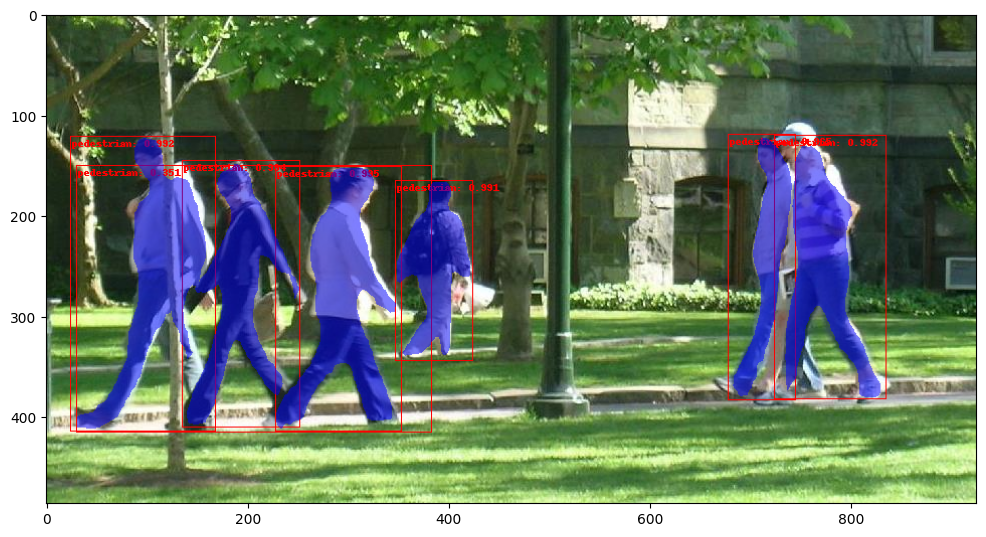

In [23]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(data_path + "/PennFudanPed/PNGImages/PennPed00022.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...] # 이미지의 4번째 채널(RGBA의 A채널)

# 예측 결과의 LABEL, BOX 추출
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# MASK>0.7인 경우만 추출해 마스크 추출
masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

### 요약
이 튜토리얼에서는 사용자 정의 데이터셋에서 인스턴스 분할 모델을 위한 자체 학습 파이프라인을 생성하는 방법을 배웠습니다. 이를 위해 영상과 정답 및 분할 마스크를 반환하는 torch.utils.data.Dataset 클래스를 작성했습니다. 또한 이 새로운 데이터 셋에 대한 전송 학습(Transfer learning)을 수행하기 위해 COCO train2017에 대해 미리 학습된 Mask R-CNN 모델을 활용 했습니다.

다중머신 / 다중GPU 에서의 학습을 포함하는 더 복잡한 예제를 알고 싶다면 torchvision 저장소에 있는 references/detection/train.py 를 확인해 보세요.